In [ ]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), "src"))

import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import ASAPScheduleAnalysis
from qiskit.transpiler import InstructionDurations
from qiskit.visualization import plot_histogram

# from qiskit.transpiler import Target as target
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider.backends import FakeTorontoV2

from DecoherenceWatchdogPass import (
    DecoherenceWatchdog,
    deflate_circuit,
    create_benchmark_circuit,
    post_select_results,
    calculate_ghz_fidelity,
    get_5bit_probs_for_post_selected,
    expand_to_5bit_with_herald_0,
    normalize_counts,
)

In [2]:
sns.set_style("whitegrid")

In [3]:
print("\n1. Setting up simulation environment...")
backend = FakeTorontoV2()
noise_model = NoiseModel.from_backend(backend)
target = backend.target


1. Setting up simulation environment...


In [4]:
ideal_sim = AerSimulator()
noisy_sim = AerSimulator(noise_model=noise_model)

In [5]:
shots = 8192
qc_bench = create_benchmark_circuit()
print(f"   Benchmark circuit '{qc_bench.name}' created.")
print(f"   Using backend '{backend.name}' for noise and transpilation properties.")

   Benchmark circuit 'GHZ_Benchmark_Circuit' created.
   Using backend 'fake_toronto' for noise and transpilation properties.


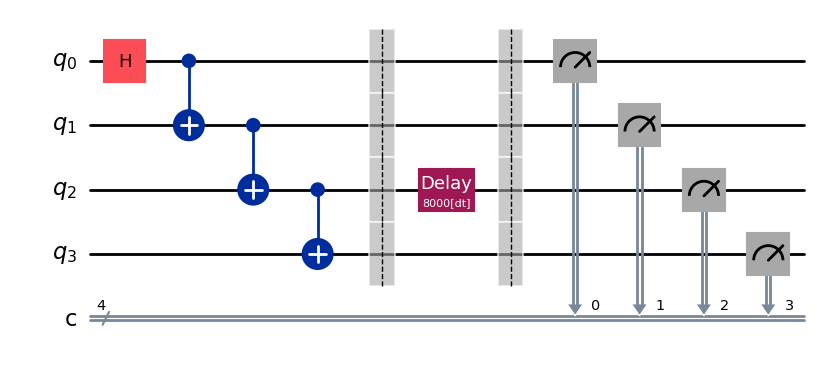

In [6]:
qc_bench.draw(output="mpl")

In [7]:
# 2. Ideal Run (Ground Truth)
print("\n2. Running Ideal (Noiseless) Simulation...")
ideal_t_qc = transpile(qc_bench, ideal_sim)
ideal_result = ideal_sim.run(ideal_t_qc, shots=shots).result()
ideal_counts = ideal_result.get_counts()


2. Running Ideal (Noiseless) Simulation...


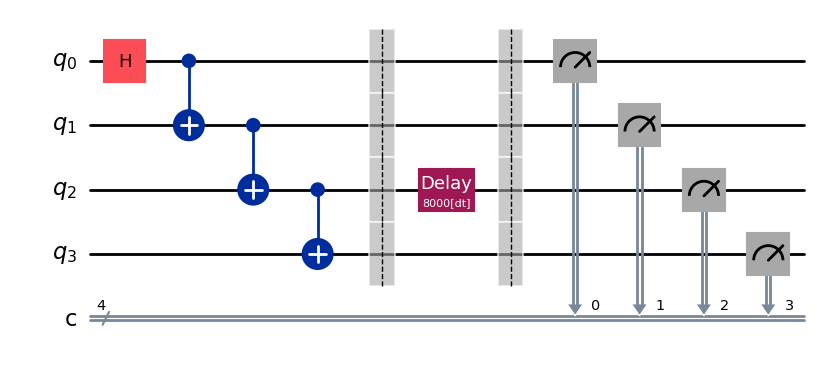

In [8]:
ideal_t_qc.draw(output="mpl")

In [9]:
# 3. Standard Noisy Run (Qiskit's Default Optimization)
print("\n3. Running Standard Noisy Simulation (opt_level=3)...")
std_t_qc = transpile(qc_bench, backend=backend, optimization_level=3)
std_result = noisy_sim.run(std_t_qc, shots=shots).result()
std_counts = std_result.get_counts()


3. Running Standard Noisy Simulation (opt_level=3)...


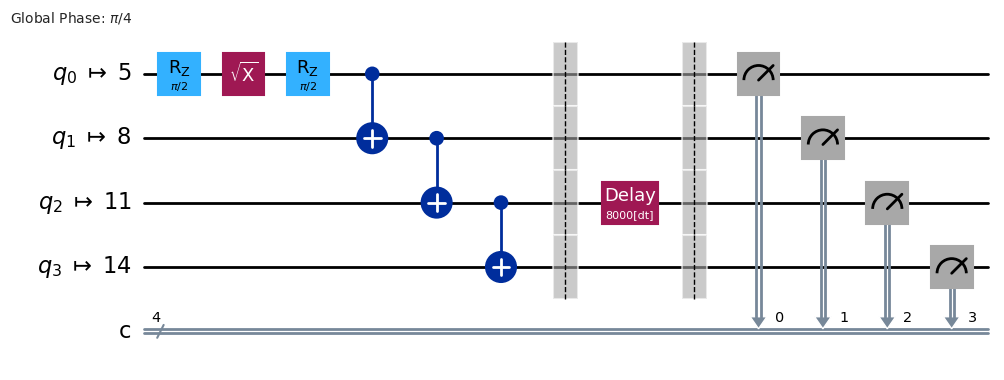

In [10]:
std_t_qc.draw(output="mpl")

In [11]:
print(f"   Pre-transpiled circuit has {std_t_qc.num_qubits} qubits")
print(
    f"   Backend has {backend.num_qubits} qubits, can accommodate up to {backend.num_qubits - 1} + 1 ancilla"
)

   Pre-transpiled circuit has 27 qubits
   Backend has 27 qubits, can accommodate up to 26 + 1 ancilla


In [12]:
# 4. Watchdog Noisy Run
print("\n4. Running Watchdog-Enhanced Noisy Simulation...")

# First, transpile the circuit to the backend's basis gates
# This ensures we have the correct gates for scheduling
# Reserve one qubit for the watchdog ancilla by limiting the initial layout
num_qubits_to_use = min(
    qc_bench.num_qubits + 3, backend.num_qubits - 1
)  # Leave room for ancilla
available_qubits = list(range(num_qubits_to_use))
pre_transpiled_qc = transpile(
    qc_bench,
    backend=backend,
    optimization_level=0,
    initial_layout=available_qubits[: qc_bench.num_qubits],
)


4. Running Watchdog-Enhanced Noisy Simulation...


In [13]:
print(f"   Pre-transpiled circuit has {pre_transpiled_qc.num_qubits} qubits")
print(
    f"   Backend has {backend.num_qubits} qubits, can accommodate up to {backend.num_qubits - 1} + 1 ancilla"
)

   Pre-transpiled circuit has 27 qubits
   Backend has 27 qubits, can accommodate up to 26 + 1 ancilla


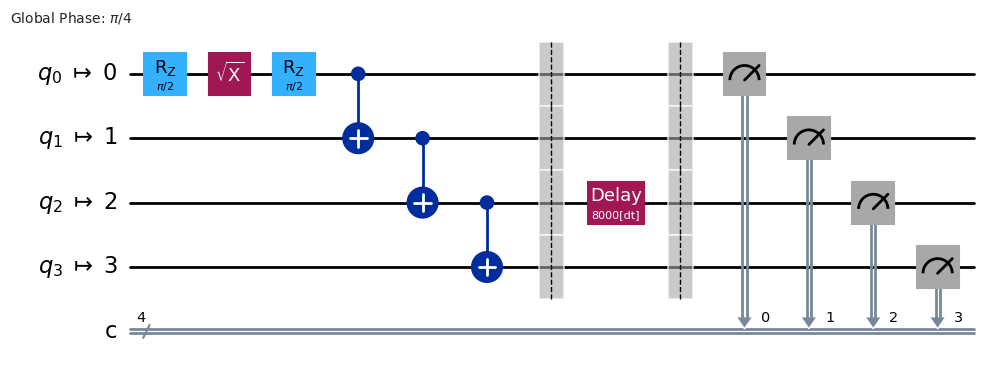

In [14]:
pre_transpiled_qc.draw(output="mpl")

In [15]:
# Deflate the circuit to remove unused qubits
pre_transpiled_qc = deflate_circuit(pre_transpiled_qc)

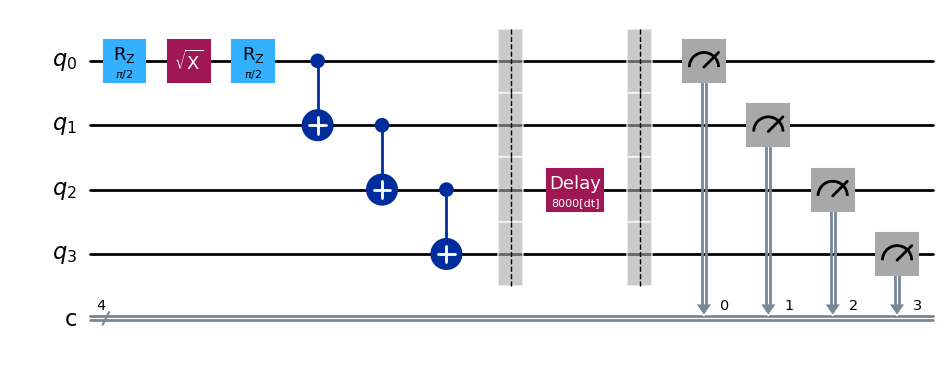

In [16]:
pre_transpiled_qc.draw(output="mpl")

In [17]:
print(f"   Pre-transpiled circuit has {pre_transpiled_qc.num_qubits} qubits")
print(
    f"   Backend has {backend.num_qubits} qubits, can accommodate up to {backend.num_qubits - 1} + 1 ancilla"
)

   Pre-transpiled circuit has 4 qubits
   Backend has 27 qubits, can accommodate up to 26 + 1 ancilla


In [18]:
# Create the custom pass and the pass manager
# The PassManager ensures the passes run in the correct order.
# We must schedule the circuit *before* our p
watchdog_pass = DecoherenceWatchdog(backend)

In [19]:
# Create instruction durations for scheduling
durations = InstructionDurations.from_backend(backend)

# Run scheduling first, then our watchdog pass
schedule_pm = PassManager([ASAPScheduleAnalysis(durations)])
scheduled_qc = schedule_pm.run(pre_transpiled_qc)

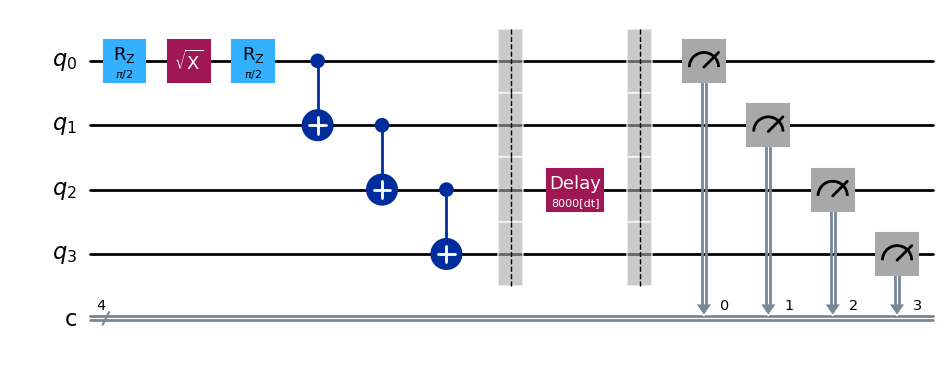

In [20]:
scheduled_qc.draw(output="mpl")

In [21]:
# Now run our watchdog pass on the scheduled circuit
watchdog_pm = PassManager([watchdog_pass])
watchdog_qc = watchdog_pm.run(scheduled_qc)

[WatchdogPass] Analyzing circuit for vulnerabilities...
[WatchdogPass] Found most vulnerable spot on qubit 2 with vulnerability score: 0.0150
[WatchdogPass] Gadget sequence inserted on data qubit 2 using ancilla qubit 4.


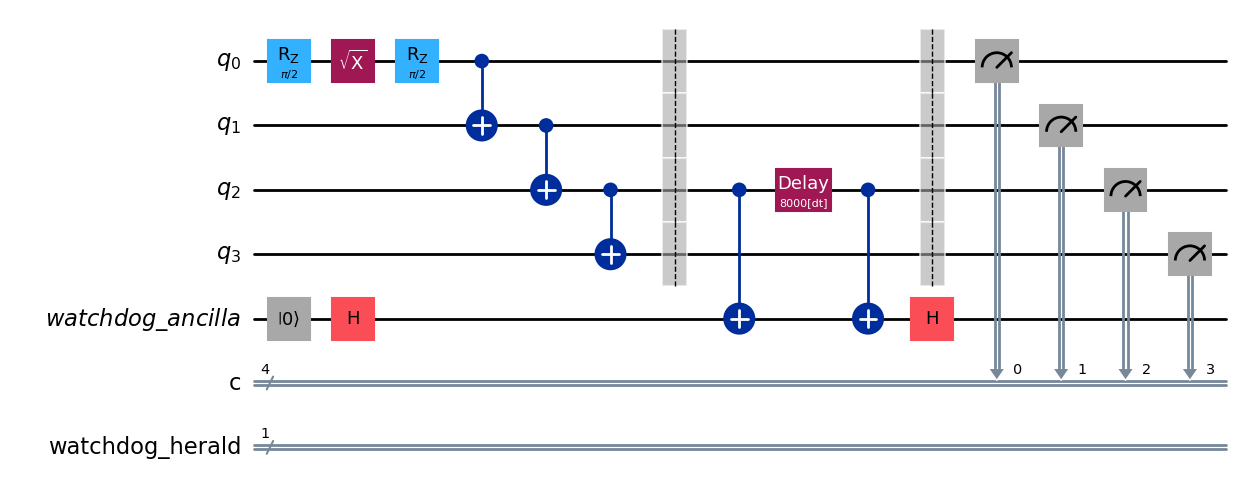

In [22]:
watchdog_qc.draw(output="mpl")

In [23]:
print(
    f"   Circuit after watchdog has {watchdog_qc.num_qubits} qubits and {watchdog_qc.num_clbits} classical bits"
)

   Circuit after watchdog has 5 qubits and 5 classical bits


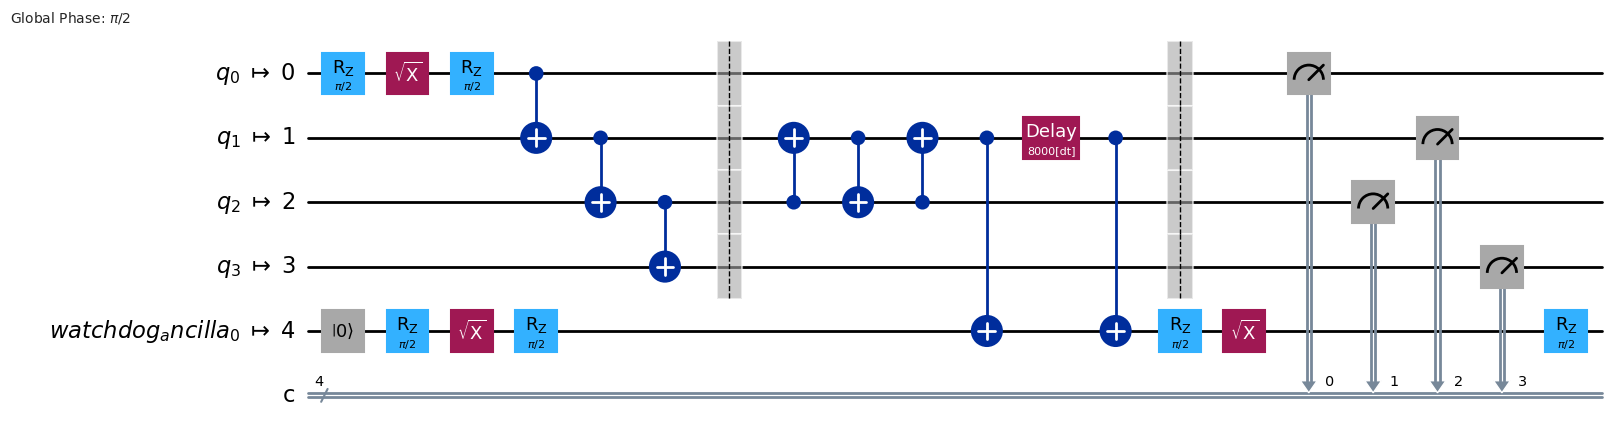

In [24]:
try:
    # First transpile with optimization
    watchdog_t_qc = transpile(
        watchdog_qc, backend=backend, optimization_level=0, initial_layout=None
    )  # Let transpiler choose layout
except Exception as e:
    print(f"   Error during transpilation: {e}")

watchdog_t_qc.draw(output="mpl")

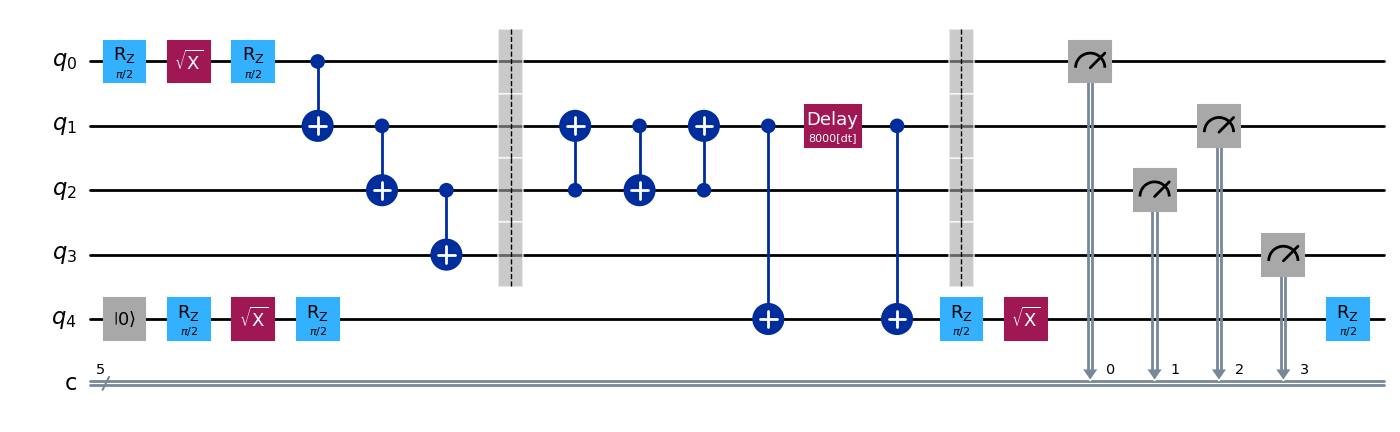

In [25]:
try:
    watchdog_t_qc = deflate_circuit(watchdog_t_qc)
except Exception as e:
    print(f"   Error during deflation: {e}")

watchdog_t_qc.draw(output="mpl")

In [26]:
print("\n   Executing watchdog circuit on noisy simulator...")
watchdog_result = noisy_sim.run(watchdog_t_qc, shots=shots).result()
watchdog_raw_counts = watchdog_result.get_counts()


   Executing watchdog circuit on noisy simulator...


In [27]:
print("   Sample raw watchdog outcomes (first 5):")
sample_outcomes = list(watchdog_raw_counts.keys())[:5]
for outcome in sample_outcomes:
    print(f"     {outcome} -> {watchdog_raw_counts[outcome]} counts")

   Sample raw watchdog outcomes (first 5):
     01010 -> 68 counts
     00000 -> 3695 counts
     00010 -> 70 counts
     01101 -> 326 counts
     01111 -> 1561 counts


In [28]:
# Post-select the watchdog results
num_data_clbits = qc_bench.num_clbits
# The herald bit is the last classical bit added. In Qiskit's little-endian format,
# it should be at the leftmost position (highest index) in the bit string
herald_bit_index = 0  # Leftmost bit in little-endian format

In [29]:
# Only post-select if we actually used the watchdog circuit
if watchdog_qc.num_clbits > num_data_clbits:
    watchdog_ps_counts, discarded_frac = post_select_results(
        watchdog_raw_counts, herald_bit_index, num_data_clbits
    )
else:
    # If we fell back to standard circuit, no post-selection needed
    watchdog_ps_counts = watchdog_raw_counts
    discarded_frac = 0.0
    print("   No post-selection performed (fallback to standard circuit)")

In [30]:
# 5. Analyze and Report GHZ Fidelity
print("\n--- GHZ Benchmark Results ---")


ideal_ghz_fid, ideal_0000, ideal_1111 = calculate_ghz_fidelity(
    ideal_counts, "1) Noiseless Ideal"
)
std_ghz_fid, std_0000, std_1111 = calculate_ghz_fidelity(
    std_counts, "2) Noisy with Optimization=3"
)
raw_ghz_fid, raw_0000, raw_1111 = calculate_ghz_fidelity(
    watchdog_raw_counts, "3) Noisy with Custom Transpiler"
)
ps_ghz_fid, ps_0000, ps_1111 = calculate_ghz_fidelity(
    watchdog_ps_counts, "4) Noisy with Discarded Runs", is_post_selected=True
)

print("\n--- GHZ Fidelity Summary ---")
print(f"Ideal GHZ Fidelity:           {ideal_ghz_fid:.4f}")
print(f"Standard GHZ Fidelity:        {std_ghz_fid:.4f}")
print(f"Watchdog Raw GHZ Fidelity:    {raw_ghz_fid:.4f}")
print(f"Watchdog PS GHZ Fidelity:     {ps_ghz_fid:.4f}")
print(
    f"Improvement (PS vs Standard): {((ps_ghz_fid - std_ghz_fid) / std_ghz_fid) * 100:+.2f}%"
)
print(f"Shot Discard Fraction:        {discarded_frac:.2%}")


--- GHZ Benchmark Results ---

1) Noiseless Ideal:
  P(|0000⟩): 0.4922
  P(|1111⟩): 0.5078
  GHZ Fidelity: 1.0000
  Other states: 0.0000

2) Noisy with Optimization=3:
  P(|0000⟩): 0.4819
  P(|1111⟩): 0.3422
  GHZ Fidelity: 0.8241
  Other states: 0.1759

3) Noisy with Custom Transpiler:
  P(|0000⟩): 0.4510
  P(|1111⟩): 0.1906
  GHZ Fidelity: 0.6416
  Other states: 0.3584

4) Noisy with Discarded Runs:
  P(|0000⟩): 0.4510
  P(|1111⟩): 0.1906
  GHZ Fidelity: 0.6416
  Other states: 0.3584

--- GHZ Fidelity Summary ---
Ideal GHZ Fidelity:           1.0000
Standard GHZ Fidelity:        0.8241
Watchdog Raw GHZ Fidelity:    0.6416
Watchdog PS GHZ Fidelity:     0.6416
Improvement (PS vs Standard): -22.14%
Shot Discard Fraction:        0.00%


In [31]:
# 6. Plot Histograms for all four cases
print("\nGenerating comprehensive comparison histogram...")


# Create 5-qubit probability distributions for all cases
ideal_5bit_probs = normalize_counts(expand_to_5bit_with_herald_0(ideal_counts))
std_5bit_probs = normalize_counts(expand_to_5bit_with_herald_0(std_counts))
raw_5bit_probs = normalize_counts(watchdog_raw_counts)
ps_5bit_probs = get_5bit_probs_for_post_selected(
    watchdog_ps_counts, watchdog_raw_counts
)

# Print shot statistics
print(f"   1) Ideal shots: {sum(ideal_counts.values())}")
print(f"   2) Standard shots: {sum(std_counts.values())}")
print(f"   3) Watchdog raw shots: {sum(watchdog_raw_counts.values())}")
print(f"   4) Watchdog post-selected shots: {sum(watchdog_ps_counts.values())}")


Generating comprehensive comparison histogram...
   1) Ideal shots: 8192
   2) Standard shots: 8192
   3) Watchdog raw shots: 8192
   4) Watchdog post-selected shots: 8192


In [32]:
# Create histogram with all four 5-qubit distributions
legend = [
    f"1) Ideal (GHZ: {ideal_ghz_fid:.3f})",
    f"2) Standard (GHZ: {std_ghz_fid:.3f})",
    f"3) Watchdog Raw (GHZ: {raw_ghz_fid:.3f})",
    f"4) Watchdog PS (GHZ: {ps_ghz_fid:.3f})",
]
hist_data = [ideal_5bit_probs, std_5bit_probs, raw_5bit_probs, ps_5bit_probs]

In [33]:
fig = plot_histogram(
    hist_data,
    legend=legend,
    figsize=(20, 10),
    title="GHZ State Analysis: 5-Qubit Probability Distributions",
    bar_labels=False,
)
ax = fig.gca()
ax.set_ylabel("Probability")
ax.yaxis.grid(True, linestyle="--")

plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [34]:
plt.show()